In [ ]:
# Copyright 2025 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Demo Plan: BigQuery for Agent Plugin + Conversational Analytics

**_NOTE_**: This notebook has been tested in the following environment:

* Python version = 3.10+

### Costs
This tutorial uses billable components of Google Cloud:
* BigQuery (storage and compute)
* Vertex AI (Gemini models for analysis)

Learn about [BigQuery pricing](https://cloud.google.com/bigquery/pricing) and [Vertex AI pricing](https://cloud.google.com/vertex-ai/pricing).

## Environment setup

Complete the tasks in this section to set up your environment.
This section includes
1. Authentication
2. Agent and plugin setup to stream events into BigQuery table
3. Initialize BQ client for further analysis of the agent events

In [38]:
# Authentication
from google.colab import auth as google_auth
google_auth.authenticate_user()
print('Authenticated')

Authenticated


In [39]:
# Import Libraries & Initialize Plugin, Tools, Models and Agent
import google.auth
import os
from google.adk.agents import Agent
from google.adk.apps import App
from google.adk.models.google_llm import Gemini
from google.adk.plugins.bigquery_agent_analytics_plugin import BigQueryAgentAnalyticsPlugin
from google.adk.tools.bigquery import BigQueryCredentialsConfig, BigQueryToolset
from google.adk.tools.tool_context import ToolContext

# Configuration
PROJECT_ID = "hyohanna-sandbox"  # @param {type:"string"}
DATASET_ID = "dataset_with_agent_event"  # @param {type:"string"}
TABLE_ID = "0208_Yohanna_table_with_ny_agent_logging"  # @param {type:"string"}
LOCATION = "us-central1"  # @param {type:"string"}

# Ensure environment variables are set for ADK/Vertex AI
os.environ["GOOGLE_CLOUD_PROJECT"] = PROJECT_ID
os.environ["GOOGLE_CLOUD_LOCATION"] = (
    "us-central1"  # Do not use US or EU since they are not compatible with Vertex AI endpoint
)
os.environ["GOOGLE_GENAI_USE_VERTEXAI"] = (
    "True"  # Make sure you have Vertex AI API enabled
)

# --- Initialize the Plugin ---
bq_logging_plugin = BigQueryAgentAnalyticsPlugin(
    project_id=PROJECT_ID,  # project_id is required input from user
    dataset_id=DATASET_ID,  # dataset_id is required input from user
    table_id=TABLE_ID,
    # Optional: defaults to "agent_events". The plugin automatically creates
    # this table if it doesn't exist.
)
print(f"BigQueryAgentAnalyticsPlugin initialized, streaming data to {PROJECT_ID}:{DATASET_ID}.{TABLE_ID}")

# --- Initialize Tools & Model ---
credentials, _ = google.auth.default(
    scopes=["https://www.googleapis.com/auth/cloud-platform"]
)
bigquery_toolset = BigQueryToolset(
    credentials_config=BigQueryCredentialsConfig(credentials=credentials)
)

llm = Gemini(
    model="gemini-2.5-flash",
)

def set_state(key: str, value: str, tool_context: ToolContext) -> str:
  """Sets a key-value pair in the session state."""
  tool_context.state[key] = value
  return f"Set state {key} to {value}"


root_agent = Agent(
    model=llm,
    name="my_bq_agent",
    instruction=(
        "You are a helpful assistant with access to BigQuery tools. You can"
        " also set session state using the `set_state` tool."
    ),
    tools=[bigquery_toolset, set_state],
    generate_content_config={
        "temperature": 0.5,
        "top_p": 0.9,
    },
)

# --- Create the App ---
app = App(
    name="my_bq_agent",
    root_agent=root_agent,
    plugins=[bq_logging_plugin], # Register the plugin here
)
print(f"my_bq_agent initialized for project {PROJECT_ID}, dataset {DATASET_ID}")

BigQueryAgentAnalyticsPlugin initialized, streaming data to hyohanna-sandbox:dataset_with_agent_event.0208_Yohanna_table_with_ny_agent_logging
my_bq_agent initialized for project hyohanna-sandbox, dataset dataset_with_agent_event


In [40]:
# Import Libraries & Initialize BigQuery Clients
from google.cloud import bigquery
import pandas as pd
import json
import os

# Initialize BigQuery Client
bq_client = bigquery.Client(project=PROJECT_ID, location=LOCATION)
print(f"BigQuery client initialized for project {PROJECT_ID}, dataset {DATASET_ID}")

# Helper function to run BigQuery jobs
def run_bq_query(sql):
    return bq_client.query(sql).to_dataframe()

def run_bq_job(sql):
    bq_client.query(sql).result()
    print("BigQuery job finished.")

BigQuery client initialized for project hyohanna-sandbox, dataset dataset_with_agent_event


## Phase 1: Understand the Agent Logging Table

In [41]:
### Real-time Feed from my_bq_bot

TABLE_ID = "0208_Yohanna_table_with_ny_agent_logging"  # @param {type:"string"}

print("Fetching latest My_bq_bot events...")
query = f"""
SELECT timestamp, event_type, session_id, user_id, TO_JSON_STRING(content) as content, error_message, status
FROM `{PROJECT_ID}.{DATASET_ID}.{TABLE_ID}`

ORDER BY timestamp DESC
LIMIT 200
"""
try:
    df_events = run_bq_query(query)
    print(df_events.to_markdown(index=False))
except Exception as e:
    print(f"Error querying events (maybe run simulation first?): {e}")

Fetching latest My_bq_bot events...
| timestamp                        | event_type            | session_id                           | user_id   | content                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

Alternatively, you can achieve the same result using the new feature [Conversational Analytics](https://docs.cloud.google.com/bigquery/docs/conversational-analytics) recently introduced by BigQuery to understand your data.

Conversational analytics in BigQuery lets you chat with agents about your data using natural language. The setup is pretty straightforward as shown below.

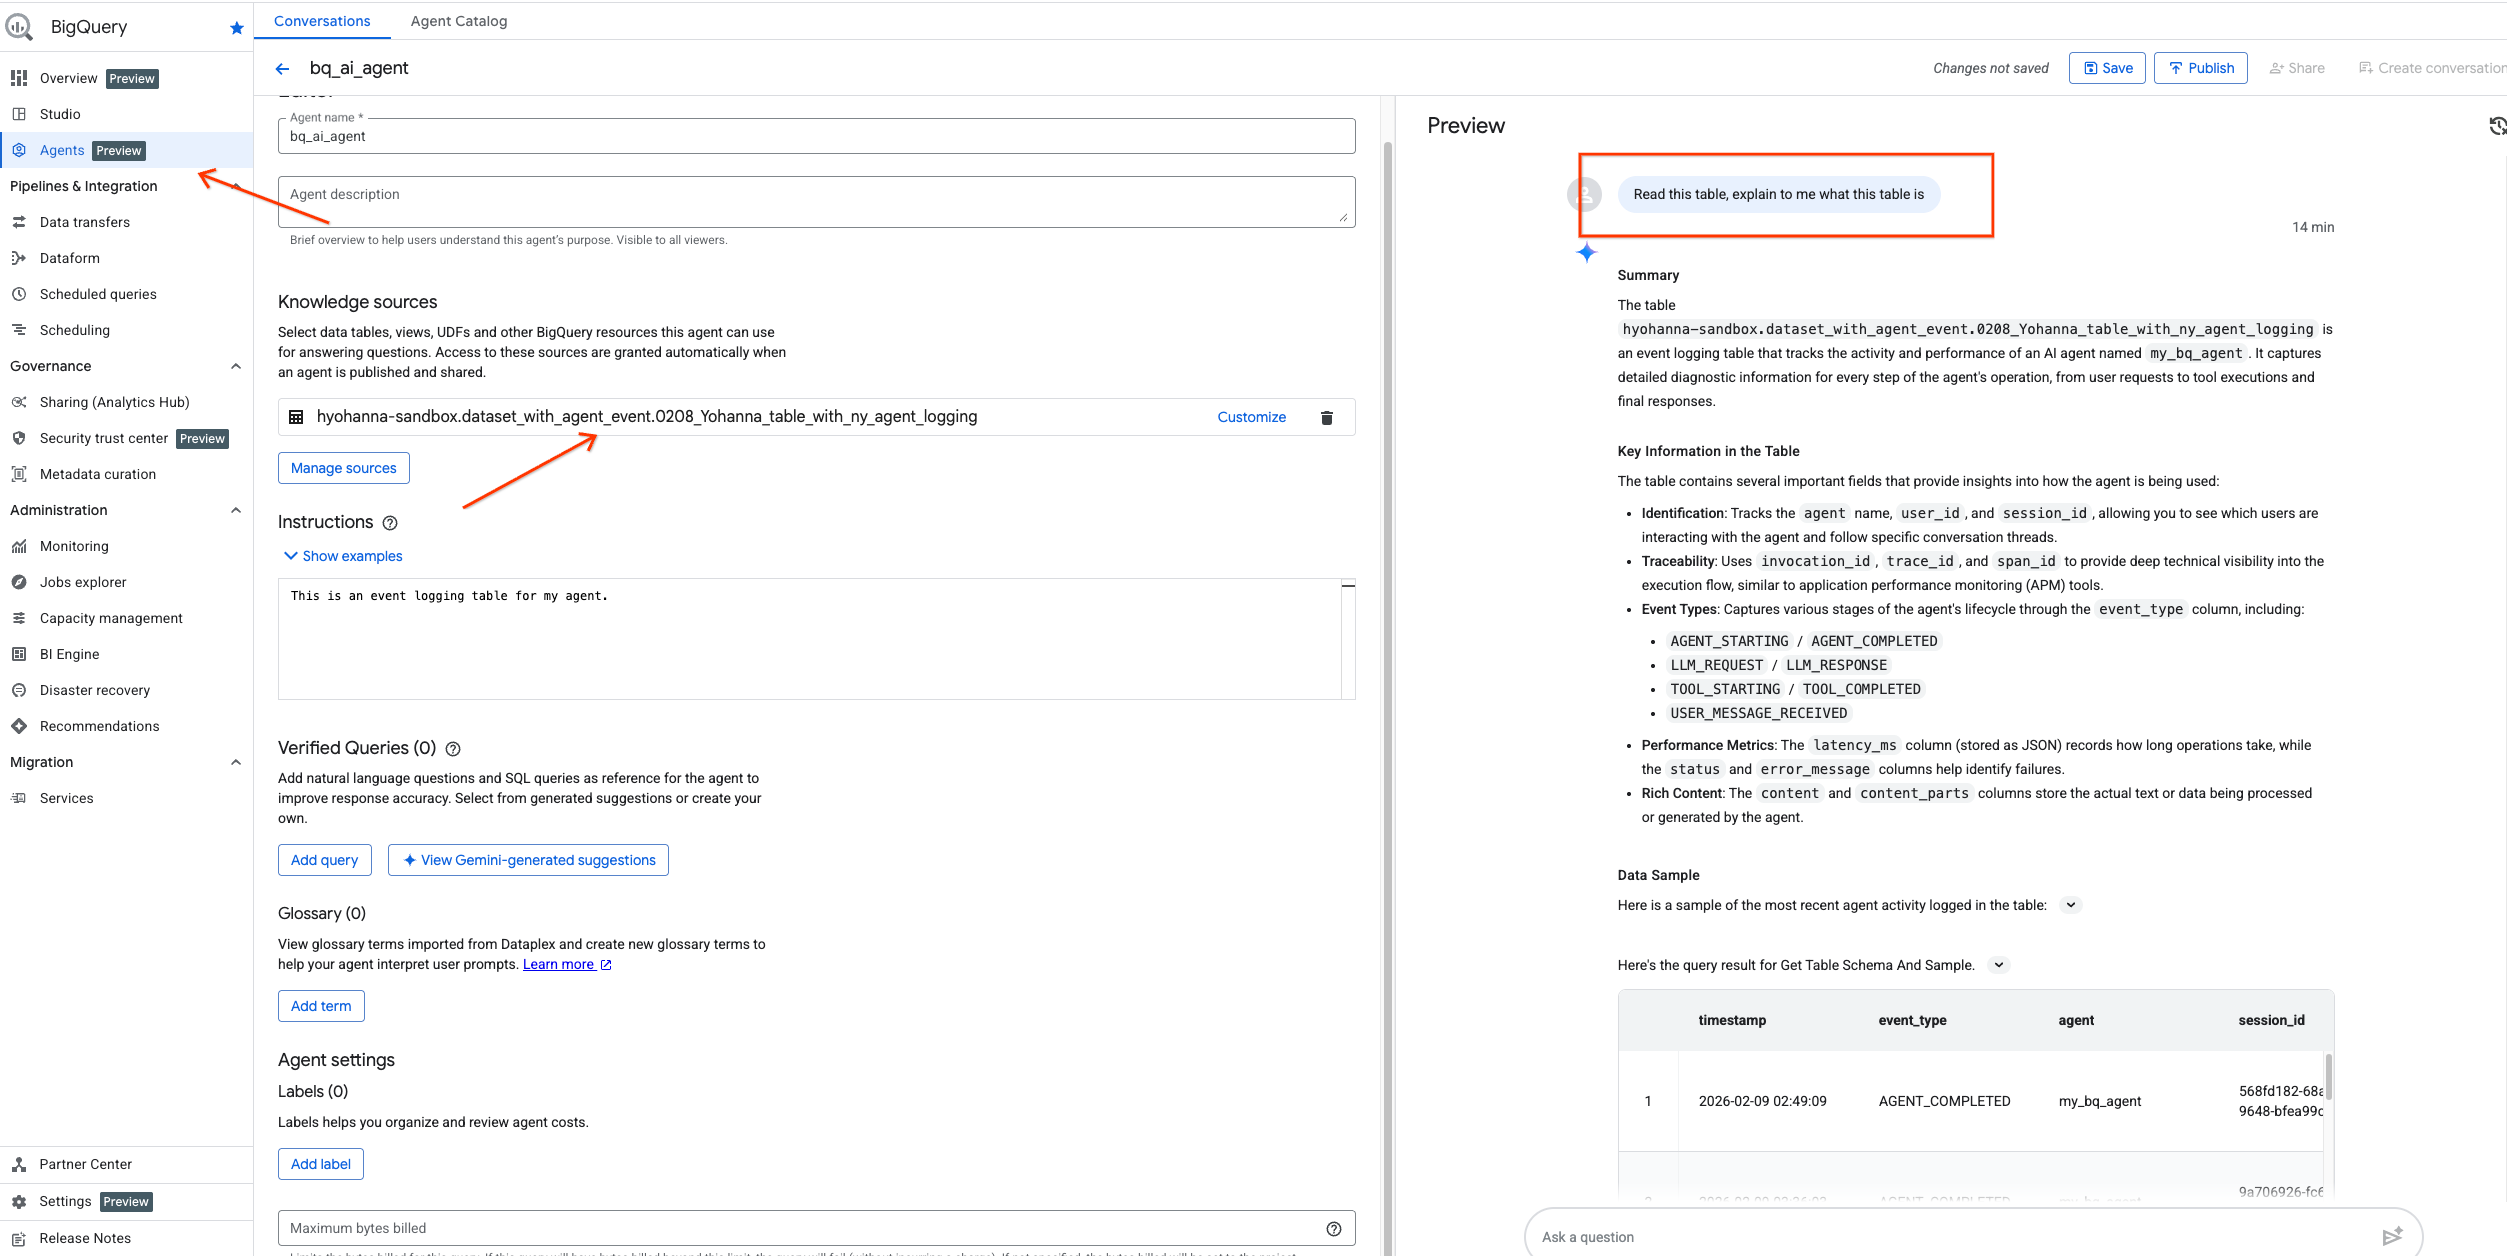

It can even illustrate the possibilities of what you can achieve within BigQuery.

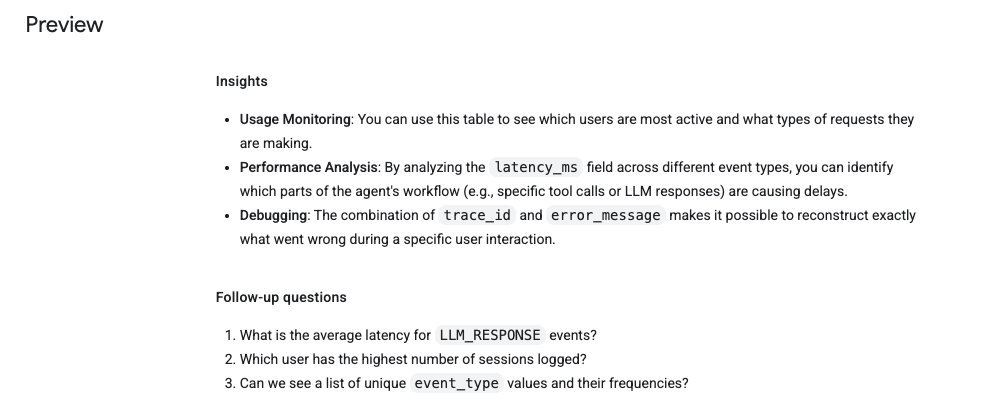

## Phase 2: Some Basic Data Analysis

In [42]:
print("\n--- Usage Monitoring ---")
usage_sql = f"""
SELECT
    user_id,
    COUNT(DISTINCT session_id) AS total_sessions,
    COUNT(DISTINCT invocation_id) AS total_invocations,
    COUNT(*) AS total_events,
    MIN(timestamp) AS first_activity,
    MAX(timestamp) AS last_activity
FROM `{PROJECT_ID}.{DATASET_ID}.{TABLE_ID}`
WHERE agent = 'my_bq_agent'
GROUP BY user_id
ORDER BY total_invocations DESC
LIMIT 10;
"""
try:
    df_usage = run_bq_query(usage_sql)
    print(df_usage.to_markdown(index=False))
except Exception as e:
    print(f"Error: {e}")


--- Usage Monitoring ---
| user_id   |   total_sessions |   total_invocations |   total_events | first_activity                   | last_activity                    |
|:----------|-----------------:|--------------------:|---------------:|:---------------------------------|:---------------------------------|
| user1     |                1 |                   8 |             81 | 2026-02-09 02:47:53.589528+00:00 | 2026-02-09 02:54:36.255581+00:00 |
| user3     |                1 |                   8 |             81 | 2026-02-09 03:23:50.080148+00:00 | 2026-02-09 03:29:24.200739+00:00 |
| user2     |                1 |                   5 |             51 | 2026-02-09 03:35:06.158324+00:00 | 2026-02-09 03:38:15.056384+00:00 |
| user4     |                1 |                   3 |             34 | 2026-02-09 03:38:59.909871+00:00 | 2026-02-09 03:51:53.265822+00:00 |
| user5     |                1 |                   1 |              7 | 2026-02-09 03:20:38.679917+00:00 | 2026-02-09 03:2

You can achieve the same result by asking the BigQuery agent to 'Write a SQL query for usage monitoring.' In addition to the query results, the agent provides automated insights and suggests follow-up questions to inspire a deeper dive into your data. Here is the output generated by Conversational Analytics:

**Insight**
* **Top Users:** user1 and user3 are the most active, both
having recorded 8 invocations and 81 total events.
* **Activity Period:** All recorded activity took place on February 9th, 2026, within a roughly one-hour window between 02:47 and 03:53.
* **Engagement:** While most users have a single session, the number of invocations per user varies significantly, with user5 and user6 only having 1 invocation each.

**Follow-up questions**
* Can you show me the average number of events per invocation for each user?
* Which specific event_types are most common for the top users?
* Can we see the usage trend broken down by 10-minute intervals? italicized text

**Note: All the 'Insight' in the below sections are live examples of what Conversational Analytics can generate through simple natural language. Give it a spin!**

In [43]:
# Error Analysis
print("\n--- Error Analysis ---")
error_sql = f"""
SELECT timestamp, session_id, event_type, TO_JSON_STRING(content) as content, error_message
FROM `{PROJECT_ID}.{DATASET_ID}.{TABLE_ID}`
WHERE agent = 'ShopBot' AND error_message IS NOT NULL
ORDER BY timestamp DESC
LIMIT 10;
"""
try:
    df_errors = run_bq_query(error_sql)
    print(df_errors.to_markdown(index=False))
except Exception as e:
    print(f"Error: {e}")


--- Error Analysis ---
| timestamp   | session_id   | event_type   | content   | error_message   |
|-------------|--------------|--------------|-----------|-----------------|


In [44]:
# Granular Cost Tracking
print("\n--- Granular Cost Tracking ---")
cost_sql = f"""
SELECT
  session_id,
  user_id,
  COUNT(*) as interaction_count,
  -- Approximation: 4 chars per token
  SUM(LENGTH(TO_JSON_STRING(content))) / 4 AS estimated_tokens,
  -- Example cost: $0.0001 per 1k tokens
  ROUND((SUM(LENGTH(TO_JSON_STRING(content))) / 4) / 1000 * 0.0001, 6) AS estimated_cost_usd
FROM `{PROJECT_ID}.{DATASET_ID}.{TABLE_ID}`
GROUP BY session_id, user_id
ORDER BY estimated_cost_usd DESC
LIMIT 5;
"""
df_cost = run_bq_query(cost_sql)
print(df_cost.to_markdown(index=False))


--- Granular Cost Tracking ---
| session_id                           | user_id   |   interaction_count |   estimated_tokens |   estimated_cost_usd |
|:-------------------------------------|:----------|--------------------:|-------------------:|---------------------:|
| 568fd182-68a5-4952-9648-bfea99cc3056 | user1     |                  81 |           22033.2  |             0.002203 |
| aa1e2a17-a924-4ddd-b034-9999c085b9e8 | user4     |                  34 |           16537.5  |             0.001654 |
| 9a706926-fc6b-4db3-a312-9001f1a4efdc | user2     |                  51 |           11253    |             0.001125 |
| a1d0bc0f-dd7a-4da2-8a10-b5080f7c96db | user3     |                  81 |            7980.5  |             0.000798 |
| d66c245e-7d62-436f-b411-8e1a20128cb4 | user6     |                   7 |             283.75 |             2.8e-05  |


## Phase 3: Performance Analysis

In [45]:
print("\n--- Performance Analysis ---")
performance_sql = f"""
SELECT
    event_type,
    ROUND(AVG(CAST(JSON_VALUE(latency_ms, '$.total_ms') AS FLOAT64)) / 1000, 2) AS avg_latency_sec,
    ROUND(MAX(CAST(JSON_VALUE(latency_ms, '$.total_ms') AS FLOAT64)) / 1000, 2) AS max_latency_sec,
    COUNT(*) AS event_count
FROM `{PROJECT_ID}.{DATASET_ID}.{TABLE_ID}`
WHERE agent = 'my_bq_agent'
  AND latency_ms IS NOT NULL
GROUP BY event_type
ORDER BY avg_latency_sec DESC;
"""
try:
    df_perf = run_bq_query(performance_sql)
    print(df_perf.to_markdown(index=False))
except Exception as e:
    print(f"Error: {e}")


--- Performance Analysis ---
| event_type      |   avg_latency_sec |   max_latency_sec |   event_count |
|:----------------|------------------:|------------------:|--------------:|
| AGENT_COMPLETED |              7.09 |             28.38 |            25 |
| TOOL_COMPLETED  |              3.87 |             23.27 |            19 |
| LLM_RESPONSE    |              2.32 |              5.95 |            45 |


**Insights**
* **Bottleneck Identification:** TOOL_COMPLETED events show a high maximum latency of over 23 seconds, which is much higher than the average of 3.87 seconds. This suggests that while most tool calls are fast, a few outliers are significantly impacting performance.
* **LLM Efficiency:** The language model responses are relatively fast and consistent, with an average latency of 2.32 seconds.
* **End-to-End Latency:** The AGENT_COMPLETED metric tells you the total time a user waits for a complete response, which averages around 7 seconds.

In [46]:
print("\n--- Slowest Tool Calls Analysis ---")
slow_tools_sql = f"""
SELECT
    JSON_VALUE(content, '$.tool') AS tool_name,
    ROUND(CAST(JSON_VALUE(latency_ms, '$.total_ms') AS FLOAT64) / 1000, 2) AS latency_seconds,
    invocation_id,
    user_id,
    timestamp
FROM `{PROJECT_ID}.{DATASET_ID}.{TABLE_ID}`
WHERE agent = 'my_bq_agent'
  AND event_type = 'TOOL_COMPLETED'
  AND JSON_VALUE(latency_ms, '$.total_ms') IS NOT NULL
ORDER BY latency_seconds DESC
LIMIT 10;
"""
try:
    df_slow = run_bq_query(slow_tools_sql)
    print(df_slow.to_markdown(index=False))
except Exception as e:
    print(f"Error: {e}")


--- Slowest Tool Calls Analysis ---
| tool_name         |   latency_seconds | invocation_id                          | user_id   | timestamp                        |
|:------------------|------------------:|:---------------------------------------|:----------|:---------------------------------|
| ask_data_insights |             23.27 | e-5f003b8c-ff6d-4caf-90e4-701a68374ba9 | user4     | 2026-02-09 03:51:51.396805+00:00 |
| ask_data_insights |             17.57 | e-a52bad48-d4cb-4220-b334-9c113fcdfa26 | user4     | 2026-02-09 03:50:49.799422+00:00 |
| ask_data_insights |             13.68 | e-ef65e5d5-7f65-4db3-a553-7e57018bab7f | user4     | 2026-02-09 03:39:18.573275+00:00 |
| ask_data_insights |              6.44 | e-6345b0c2-4cad-4f95-a646-81e2e8712e9c | user2     | 2026-02-09 03:37:42.009659+00:00 |
| ask_data_insights |              6.1  | e-92c907db-437f-4973-bf4d-86b9c1c224a5 | user2     | 2026-02-09 03:36:01.800984+00:00 |
| execute_sql       |              1    | e-5cf6fa52-

**Insights**
* **Bottleneck Tool:** The ask_data_insights tool is responsible for the top 5 longest tool calls, with the slowest reaching over 23 seconds. This is significantly slower than the other tools.
* **Baseline Performance:** More standard operations like SQL Execution and list_dataset_ids are much faster, typically finishing in under 1 second.
* **User Impact:** These high-latency calls are primarily impacting user4 and user2 in the current dataset, which could lead to a degraded user experience for those specific interactions.

In [47]:
print("\n--- High-Latency User Questions Analysis ---")
slow_query_sql = f"""
SELECT
    logging_table.timestamp,
    logging_table.user_id,
    JSON_VALUE(logging_table.content, '$.tool') AS tool_name,
    ROUND(CAST(JSON_VALUE(logging_table.latency_ms, '$.total_ms') AS FLOAT64) / 1000, 2) AS tool_latency_sec,
    JSON_VALUE(user_msgs.content, '$.text_summary') AS user_question
FROM `{PROJECT_ID}.{DATASET_ID}.{TABLE_ID}` AS logging_table
INNER JOIN `{PROJECT_ID}.{DATASET_ID}.{TABLE_ID}` AS user_msgs
    ON logging_table.invocation_id = user_msgs.invocation_id
WHERE logging_table.agent = 'my_bq_agent'
  AND logging_table.event_type = 'TOOL_COMPLETED'
  AND user_msgs.event_type = 'USER_MESSAGE_RECEIVED'
  AND CAST(JSON_VALUE(logging_table.latency_ms, '$.total_ms') AS FLOAT64) >= 10000
ORDER BY tool_latency_sec DESC;
"""
try:
    df_slow_queries = run_bq_query(slow_query_sql)
    print(df_slow_queries.to_markdown(index=False))
except Exception as e:
    print(f"Error: {e}")


--- High-Latency User Questions Analysis ---
| timestamp                        | user_id   | tool_name         |   tool_latency_sec | user_question                                                                                                                                                             |
|:---------------------------------|:----------|:------------------|-------------------:|:--------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| 2026-02-09 03:51:51.396805+00:00 | user4     | ask_data_insights |              23.27 | calculate the tip rate, show me the trend                                                                                                                                 |
| 2026-02-09 03:50:49.799422+00:00 | user4     | ask_data_insights |              17.57 | what about the trend in tips                                                  

**Insights**
* **Trend and Aggregate Analysis:** Requests like "calculate the tip rate, show me the trend" are the most time-consuming. These typically involve scanning multiple years of large tables (e.g., millions of NYC taxi trips), which naturally takes longer to process.
* **Data Scope:** The 13.68-second call was triggered by a request to analyze four separate tables simultaneously across a large dataset.
* **Bottleneck Tool:** In all cases, the high latency is concentrated in the ask_data_insights tool, which handles the complex logic and sub-query generation required for trend analysis.

**Leverage on BigQuery's built-in AI features**

You can also leverage on BigQuery's built-in AI feature to analyze your agent's event logging data. When you do performance analysis, this is particularly useful for Anomaly Detection (e.g., finding unexpected spikes in latency).

* **AI.DETECT_ANOMALIES:** This function can compare your recent activity against a historical baseline. It will flag any data point where the latency or usage falls outside of the expected "normal" range (the lower_bound and upper_bound).

In [48]:
print("\n--- Latency Anomaly Detection (02/09 Only) ---")
anomaly_sql_0209 = f"""
WITH base_data AS (
  SELECT
    DATE_TRUNC(timestamp, MINUTE) AS event_minute,
    AVG(CAST(JSON_VALUE(latency_ms, '$.total_ms') AS FLOAT64)) AS avg_latency_ms
  FROM `{PROJECT_ID}.{DATASET_ID}.{TABLE_ID}`
  WHERE agent = 'my_bq_agent'
    AND event_type = 'AGENT_COMPLETED'
    AND latency_ms IS NOT NULL
    AND DATE(timestamp) = '2026-02-09'
  GROUP BY 1
),
historical_data AS (
  SELECT event_minute, avg_latency_ms FROM base_data
  WHERE event_minute < '2026-02-09 03:50:00'
),
target_data AS (
  SELECT event_minute, avg_latency_ms FROM base_data
  WHERE event_minute >= '2026-02-09 03:50:00'
)
SELECT
  time_series_timestamp,
  time_series_data,
  is_anomaly,
  lower_bound,
  upper_bound,
  anomaly_probability
FROM
  AI.DETECT_ANOMALIES(
    (SELECT * FROM historical_data),
    (SELECT * FROM target_data),
    data_col => 'avg_latency_ms',
    timestamp_col => 'event_minute'
  )
ORDER BY time_series_timestamp DESC;
"""
try:
    df_anomalies_0209 = run_bq_query(anomaly_sql_0209)
    print(df_anomalies_0209.to_markdown(index=False))
except Exception as e:
  print(f"Error: {e}")


--- Latency Anomaly Detection (02/09 Only) ---
| time_series_timestamp     |   time_series_data | is_anomaly   |   lower_bound |   upper_bound |   anomaly_probability |
|:--------------------------|-------------------:|:-------------|--------------:|--------------:|----------------------:|
| 2026-02-09 03:53:00+00:00 |               5982 | False        |      -2135.43 |       48172   |              0.497746 |
| 2026-02-09 03:51:00+00:00 |              28379 | False        |      -3007.7  |       49576.5 |              0.61526  |
| 2026-02-09 03:50:00+00:00 |              24935 | False        |      -3259.99 |       50828.7 |              0.482176 |


**Insights**
* **Statistical Normality:** Despite the average latency reaching 28.3 seconds at 03:51 AM, the model did not flag this as an anomaly (is_anomaly = false).
* **High Confidence Bounds:** The upper_bound for expected latency is very high (approx. 49 seconds). This indicates that because the agent handles varied and complex queries (like the multi-year taxi analysis we found earlier), a wide range of response times is considered "statistically normal" for this specific workload.
* **Probability:** The anomaly probability for the 03:51 AM spike was 0.61, which is elevated but below the default threshold (usually 0.95 or 0.99) required to trigger a formal anomaly flag.
* Of course, you can always lower the anomaly threshold to be more sensitive to delays.

## Phase 4: Understand and Protect Your User

To run a successful agent, sometimes you want to understand your user better. BigQuery's AI feature can help transform raw log data into structured insights without needing external machine learning pipelines.

In [49]:
print("\n--- AI-Driven User Intent Analysis ---")
ai_user_analysis_sql = f"""
WITH user_messages AS (
  SELECT
    timestamp,
    user_id,
    JSON_VALUE(content, '$.text_summary') AS raw_message
  FROM `{PROJECT_ID}.{DATASET_ID}.{TABLE_ID}`
  WHERE agent = 'my_bq_agent'
    AND event_type = 'USER_MESSAGE_RECEIVED'
    AND JSON_VALUE(content, '$.text_summary') IS NOT NULL
  ORDER BY timestamp DESC
  LIMIT 10
)
SELECT
  timestamp,
  user_id,
  raw_message,
  -- Generate a short summary of the user's question
  AI.GENERATE(
    CONCAT('Summarize this user request in 5 words or less: ', raw_message)
  ).result AS ai_summary,
  -- Categorize the message into predefined intent buckets
  AI.CLASSIFY(
    raw_message,
    categories => ['Trend Analysis', 'Data Exploration', 'Location Service', 'Security', 'Other']
  ) AS ai_intent
FROM user_messages;
"""
try:
    df_ai_analysis = run_bq_query(ai_user_analysis_sql)
    print(df_ai_analysis.to_markdown(index=False))
except Exception as e:
    print(f"Error: {e}")



--- AI-Driven User Intent Analysis ---
| timestamp                        | user_id   | raw_message                                                                                                                                                               | ai_summary                                  | ai_intent        |
|:---------------------------------|:----------|:--------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:--------------------------------------------|:-----------------|
| 2026-02-09 03:29:20.372709+00:00 | user3     | is the data still accurate                                                                                                                                                | Data accuracy check                         | Data Exploration |
| 2026-02-09 03:37:33.498211+00:00 | user2     | what's the trend of the fare amount over these years 

* **AI.CLASSIFY:** The AI.CLASSIFY function successfully distinguished between "Trend Analysis" (e.g., fare trends) and "Location Services" (e.g., bike availability), allowing you to see exactly which features of your agent are most popular.
* **AI.GENERATE:** The AI.GENERATE function condensed a long list of specific table names (from the 03:35 AM request) into a simple summary: "Analyze green trips, 2013-2016." This makes high-level reporting much cleaner.

In [50]:
print("\n--- AI Intent: Volume vs. Performance Analysis ---")
intent_perf_sql = f"""
WITH categorized_messages AS (
    SELECT
        invocation_id,
        AI.CLASSIFY(JSON_VALUE(content, '$.text_summary'),
                    categories => ['Trend Analysis', 'Data Exploration', 'Location Service', 'Security', 'Other']) AS ai_intent
    FROM `{PROJECT_ID}.{DATASET_ID}.{TABLE_ID}`
    WHERE event_type = 'USER_MESSAGE_RECEIVED'
      AND agent = 'my_bq_agent'
      AND JSON_VALUE(content, '$.text_summary') IS NOT NULL
),
invocation_performance AS (
    SELECT
        invocation_id,
        MAX(CAST(JSON_VALUE(latency_ms, '$.total_ms') AS FLOAT64)) AS total_invocation_latency_ms
    FROM `{PROJECT_ID}.{DATASET_ID}.{TABLE_ID}`
    WHERE event_type = 'AGENT_COMPLETED'
      AND agent = 'my_bq_agent'
    GROUP BY invocation_id
)
SELECT
    cat.ai_intent,
    COUNT(DISTINCT cat.invocation_id) AS total_requests,
    ROUND(AVG(perf.total_invocation_latency_ms) / 1000, 2) AS avg_latency_seconds
FROM categorized_messages AS cat
JOIN invocation_performance AS perf ON cat.invocation_id = perf.invocation_id
GROUP BY cat.ai_intent
ORDER BY total_requests DESC;
"""
try:
    df_intent_perf = run_bq_query(intent_perf_sql)
    print(df_intent_perf.to_markdown(index=False))
except Exception as e:
    print(f"Error: {e}")


--- AI Intent: Volume vs. Performance Analysis ---
| ai_intent        |   total_requests |   avg_latency_seconds |
|:-----------------|-----------------:|----------------------:|
| Data Exploration |               12 |                  6.51 |
| Location Service |                4 |                  3.73 |
| Trend Analysis   |                4 |                 16.95 |
| Other            |                4 |                  2.61 |
| Security         |                1 |                  5.98 |


In [36]:
# dataframe: df_intent_perf
# uuid: D27140E8-6576-43A8-A5BA-0AEA3CF1E6A0
# output_variable:
# config_str: CoJFeyJjaGFydENvbmZpZyI6eyJkYXRhc291cmNlSWQiOiJfX1ZJWl9EQVRBU09VUkNFX18iLCJwcm9wZXJ0eUNvbmZpZyI6eyJjb21wb25lbnRQcm9wZXJ0eSI6eyJzb3J0IjpbeyJzb3J0RGlyIjoxLCJzb3J0Q29sdW1uIjoicXRfc3h2bTloaTAwZCJ9XSwiYnJlYWtkb3duQ29uZmlnIjpbXSwiZmlsdGVycyI6W10sImluaGVyaXRGaWx0ZXJzIjp0cnVlLCJkc1JlcXVpcmVkRmlsdGVycyI6W10sImRhdGFzZXQiOnsiZGF0YXNldFR5cGUiOjEsImRhdGFzZXRJZCI6Il9fVklaX0RBVEFTT1VSQ0VfXyJ9LCJyb3ciOjUwMCwiZGltZW5zaW9ucyI6eyJsYWJlbGVkQ29uY2VwdHMiOlt7ImtleSI6InByaW1hcnkiLCJ2YWx1ZSI6eyJjb25jZXB0TmFtZXMiOlsicXRfcXh2bTloaTAwZCJdfX1dfSwibWV0cmljcyI6eyJsYWJlbGVkQ29uY2VwdHMiOlt7ImtleSI6InByaW1hcnkiLCJ2YWx1ZSI6eyJjb25jZXB0TmFtZXMiOlsicXRfc3h2bTloaTAwZCIsInF0X3pmcmp4amkwMGQiXX19XX0sImNvbWJvQ2hhcnRQcm9wZXJ0eSI6eyJvdmVycmlkZUF4aXNBdXRvIjp0cnVlLCJzZXJpZXNQcm9wZXJ0eSI6W3sic2VyaWVzRmlsbENvbG9yIjp7ImNvbG9yIjoiI0ZGRkZGRiJ9LCJzZXJpZXNUeXBlIjowLCJzZXJpZXNDdW11bGF0aXZlIjpmYWxzZSwic2VyaWVzU2hvd1BvaW50cyI6ZmFsc2UsInNlcmllc1Nob3dEYXRhTGFiZWwiOmZhbHNlLCJzZXJpZXNBeGlzSW5kZXgiOjEsInNlcmllc0xpbmVTdHlsZSI6Miwic2VyaWVzU3RlcHBlZCI6ZmFsc2UsImxhYmVsU3R5bGVQcm9wZXJ0eSI6eyJsYWJlbHNCYWNrZ3JvdW5kQ29sb3IiOnsiY29sb3IiOiJ0cmFuc3BhcmVudCJ9LCJsYWJlbHNPcGFjaXR5IjoxfX0seyJzZXJpZXNDb2xvciI6eyJjb2xvciI6IiNFNTczNzMiLCJvcGFjaXR5IjoxfSwic2VyaWVzRmlsbENvbG9yIjp7ImNvbG9yIjoiI0ZGRkZGRiJ9LCJzZXJpZXNUeXBlIjoxLCJzZXJpZXNDdW11bGF0aXZlIjpmYWxzZSwic2VyaWVzU2hvd1BvaW50cyI6ZmFsc2UsInNlcmllc1Nob3dEYXRhTGFiZWwiOmZhbHNlLCJzZXJpZXNMaW5lU3R5bGUiOjIsInNlcmllc1N0ZXBwZWQiOmZhbHNlLCJsYWJlbFN0eWxlUHJvcGVydHkiOnsibGFiZWxzQmFja2dyb3VuZENvbG9yIjp7ImNvbG9yIjoidHJhbnNwYXJlbnQifSwibGFiZWxzT3BhY2l0eSI6MX19LHsic2VyaWVzRmlsbENvbG9yIjp7ImNvbG9yIjoiI0ZGRkZGRiJ9LCJzZXJpZXNUeXBlIjoxLCJzZXJpZXNDdW11bGF0aXZlIjpmYWxzZSwic2VyaWVzU2hvd1BvaW50cyI6ZmFsc2UsInNlcmllc1Nob3dEYXRhTGFiZWwiOmZhbHNlLCJzZXJpZXNMaW5lU3R5bGUiOjIsInNlcmllc1N0ZXBwZWQiOmZhbHNlLCJsYWJlbFN0eWxlUHJvcGVydHkiOnsibGFiZWxzQmFja2dyb3VuZENvbG9yIjp7ImNvbG9yIjoidHJhbnNwYXJlbnQifSwibGFiZWxzT3BhY2l0eSI6MX19LHsic2VyaWVzRmlsbENvbG9yIjp7ImNvbG9yIjoiI0ZGRkZGRiJ9LCJzZXJpZXNUeXBlIjoxLCJzZXJpZXNDdW11bGF0aXZlIjpmYWxzZSwic2VyaWVzU2hvd1BvaW50cyI6ZmFsc2UsInNlcmllc1Nob3dEYXRhTGFiZWwiOmZhbHNlLCJzZXJpZXNMaW5lU3R5bGUiOjIsInNlcmllc1N0ZXBwZWQiOmZhbHNlLCJsYWJlbFN0eWxlUHJvcGVydHkiOnsibGFiZWxzQmFja2dyb3VuZENvbG9yIjp7ImNvbG9yIjoidHJhbnNwYXJlbnQifSwibGFiZWxzT3BhY2l0eSI6MX19LHsic2VyaWVzRmlsbENvbG9yIjp7ImNvbG9yIjoiI0ZGRkZGRiJ9LCJzZXJpZXNUeXBlIjoxLCJzZXJpZXNDdW11bGF0aXZlIjpmYWxzZSwic2VyaWVzU2hvd1BvaW50cyI6ZmFsc2UsInNlcmllc1Nob3dEYXRhTGFiZWwiOmZhbHNlLCJzZXJpZXNMaW5lU3R5bGUiOjIsInNlcmllc1N0ZXBwZWQiOmZhbHNlLCJsYWJlbFN0eWxlUHJvcGVydHkiOnsibGFiZWxzQmFja2dyb3VuZENvbG9yIjp7ImNvbG9yIjoidHJhbnNwYXJlbnQifSwibGFiZWxzT3BhY2l0eSI6MX19LHsic2VyaWVzRmlsbENvbG9yIjp7ImNvbG9yIjoiI0ZGRkZGRiJ9LCJzZXJpZXNUeXBlIjoxLCJzZXJpZXNDdW11bGF0aXZlIjpmYWxzZSwic2VyaWVzU2hvd1BvaW50cyI6ZmFsc2UsInNlcmllc1Nob3dEYXRhTGFiZWwiOmZhbHNlLCJzZXJpZXNMaW5lU3R5bGUiOjIsInNlcmllc1N0ZXBwZWQiOmZhbHNlLCJsYWJlbFN0eWxlUHJvcGVydHkiOnsibGFiZWxzQmFja2dyb3VuZENvbG9yIjp7ImNvbG9yIjoidHJhbnNwYXJlbnQifSwibGFiZWxzT3BhY2l0eSI6MX19LHsic2VyaWVzRmlsbENvbG9yIjp7ImNvbG9yIjoiI0ZGRkZGRiJ9LCJzZXJpZXNUeXBlIjoxLCJzZXJpZXNDdW11bGF0aXZlIjpmYWxzZSwic2VyaWVzU2hvd1BvaW50cyI6ZmFsc2UsInNlcmllc1Nob3dEYXRhTGFiZWwiOmZhbHNlLCJzZXJpZXNMaW5lU3R5bGUiOjIsInNlcmllc1N0ZXBwZWQiOmZhbHNlLCJsYWJlbFN0eWxlUHJvcGVydHkiOnsibGFiZWxzQmFja2dyb3VuZENvbG9yIjp7ImNvbG9yIjoidHJhbnNwYXJlbnQifSwibGFiZWxzT3BhY2l0eSI6MX19LHsic2VyaWVzRmlsbENvbG9yIjp7ImNvbG9yIjoiI0ZGRkZGRiJ9LCJzZXJpZXNUeXBlIjoxLCJzZXJpZXNDdW11bGF0aXZlIjpmYWxzZSwic2VyaWVzU2hvd1BvaW50cyI6ZmFsc2UsInNlcmllc1Nob3dEYXRhTGFiZWwiOmZhbHNlLCJzZXJpZXNMaW5lU3R5bGUiOjIsInNlcmllc1N0ZXBwZWQiOmZhbHNlLCJsYWJlbFN0eWxlUHJvcGVydHkiOnsibGFiZWxzQmFja2dyb3VuZENvbG9yIjp7ImNvbG9yIjoidHJhbnNwYXJlbnQifSwibGFiZWxzT3BhY2l0eSI6MX19LHsic2VyaWVzRmlsbENvbG9yIjp7ImNvbG9yIjoiI0ZGRkZGRiJ9LCJzZXJpZXNUeXBlIjoxLCJzZXJpZXNDdW11bGF0aXZlIjpmYWxzZSwic2VyaWVzU2hvd1BvaW50cyI6ZmFsc2UsInNlcmllc1Nob3dEYXRhTGFiZWwiOmZhbHNlLCJzZXJpZXNMaW5lU3R5bGUiOjIsInNlcmllc1N0ZXBwZWQiOmZhbHNlLCJsYWJlbFN0eWxlUHJvcGVydHkiOnsibGFiZWxzQmFja2dyb3VuZENvbG9yIjp7ImNvbG9yIjoidHJhbnNwYXJlbnQifSwibGFiZWxzT3BhY2l0eSI6MX19LHsic2VyaWVzRmlsbENvbG9yIjp7ImNvbG9yIjoiI0ZGRkZGRiJ9LCJzZXJpZXNUeXBlIjoxLCJzZXJpZXNDdW11bGF0aXZlIjpmYWxzZSwic2VyaWVzU2hvd1BvaW50cyI6ZmFsc2UsInNlcmllc1Nob3dEYXRhTGFiZWwiOmZhbHNlLCJzZXJpZXNMaW5lU3R5bGUiOjIsInNlcmllc1N0ZXBwZWQiOmZhbHNlLCJsYWJlbFN0eWxlUHJvcGVydHkiOnsibGFiZWxzQmFja2dyb3VuZENvbG9yIjp7ImNvbG9yIjoidHJhbnNwYXJlbnQifSwibGFiZWxzT3BhY2l0eSI6MX19LHsic2VyaWVzRmlsbENvbG9yIjp7ImNvbG9yIjoiI0ZGRkZGRiJ9LCJzZXJpZXNUeXBlIjoxLCJzZXJpZXNDdW11bGF0aXZlIjpmYWxzZSwic2VyaWVzU2hvd1BvaW50cyI6ZmFsc2UsInNlcmllc1Nob3dEYXRhTGFiZWwiOmZhbHNlLCJzZXJpZXNMaW5lU3R5bGUiOjIsInNlcmllc1N0ZXBwZWQiOmZhbHNlLCJsYWJlbFN0eWxlUHJvcGVydHkiOnsibGFiZWxzQmFja2dyb3VuZENvbG9yIjp7ImNvbG9yIjoidHJhbnNwYXJlbnQifSwibGFiZWxzT3BhY2l0eSI6MX19LHsic2VyaWVzRmlsbENvbG9yIjp7ImNvbG9yIjoiI0ZGRkZGRiJ9LCJzZXJpZXNUeXBlIjoxLCJzZXJpZXNDdW11bGF0aXZlIjpmYWxzZSwic2VyaWVzU2hvd1BvaW50cyI6ZmFsc2UsInNlcmllc1Nob3dEYXRhTGFiZWwiOmZhbHNlLCJzZXJpZXNMaW5lU3R5bGUiOjIsInNlcmllc1N0ZXBwZWQiOmZhbHNlLCJsYWJlbFN0eWxlUHJvcGVydHkiOnsibGFiZWxzQmFja2dyb3VuZENvbG9yIjp7ImNvbG9yIjoidHJhbnNwYXJlbnQifSwibGFiZWxzT3BhY2l0eSI6MX19LHsic2VyaWVzRmlsbENvbG9yIjp7ImNvbG9yIjoiI0ZGRkZGRiJ9LCJzZXJpZXNUeXBlIjoxLCJzZXJpZXNDdW11bGF0aXZlIjpmYWxzZSwic2VyaWVzU2hvd1BvaW50cyI6ZmFsc2UsInNlcmllc1Nob3dEYXRhTGFiZWwiOmZhbHNlLCJzZXJpZXNMaW5lU3R5bGUiOjIsInNlcmllc1N0ZXBwZWQiOmZhbHNlLCJsYWJlbFN0eWxlUHJvcGVydHkiOnsibGFiZWxzQmFja2dyb3VuZENvbG9yIjp7ImNvbG9yIjoidHJhbnNwYXJlbnQifSwibGFiZWxzT3BhY2l0eSI6MX19LHsic2VyaWVzRmlsbENvbG9yIjp7ImNvbG9yIjoiI0ZGRkZGRiJ9LCJzZXJpZXNUeXBlIjoxLCJzZXJpZXNDdW11bGF0aXZlIjpmYWxzZSwic2VyaWVzU2hvd1BvaW50cyI6ZmFsc2UsInNlcmllc1Nob3dEYXRhTGFiZWwiOmZhbHNlLCJzZXJpZXNMaW5lU3R5bGUiOjIsInNlcmllc1N0ZXBwZWQiOmZhbHNlLCJsYWJlbFN0eWxlUHJvcGVydHkiOnsibGFiZWxzQmFja2dyb3VuZENvbG9yIjp7ImNvbG9yIjoidHJhbnNwYXJlbnQifSwibGFiZWxzT3BhY2l0eSI6MX19LHsic2VyaWVzRmlsbENvbG9yIjp7ImNvbG9yIjoiI0ZGRkZGRiJ9LCJzZXJpZXNUeXBlIjoxLCJzZXJpZXNDdW11bGF0aXZlIjpmYWxzZSwic2VyaWVzU2hvd1BvaW50cyI6ZmFsc2UsInNlcmllc1Nob3dEYXRhTGFiZWwiOmZhbHNlLCJzZXJpZXNMaW5lU3R5bGUiOjIsInNlcmllc1N0ZXBwZWQiOmZhbHNlLCJsYWJlbFN0eWxlUHJvcGVydHkiOnsibGFiZWxzQmFja2dyb3VuZENvbG9yIjp7ImNvbG9yIjoidHJhbnNwYXJlbnQifSwibGFiZWxzT3BhY2l0eSI6MX19LHsic2VyaWVzRmlsbENvbG9yIjp7ImNvbG9yIjoiI0ZGRkZGRiJ9LCJzZXJpZXNUeXBlIjoxLCJzZXJpZXNDdW11bGF0aXZlIjpmYWxzZSwic2VyaWVzU2hvd1BvaW50cyI6ZmFsc2UsInNlcmllc1Nob3dEYXRhTGFiZWwiOmZhbHNlLCJzZXJpZXNMaW5lU3R5bGUiOjIsInNlcmllc1N0ZXBwZWQiOmZhbHNlLCJsYWJlbFN0eWxlUHJvcGVydHkiOnsibGFiZWxzQmFja2dyb3VuZENvbG9yIjp7ImNvbG9yIjoidHJhbnNwYXJlbnQifSwibGFiZWxzT3BhY2l0eSI6MX19LHsic2VyaWVzRmlsbENvbG9yIjp7ImNvbG9yIjoiI0ZGRkZGRiJ9LCJzZXJpZXNUeXBlIjoxLCJzZXJpZXNDdW11bGF0aXZlIjpmYWxzZSwic2VyaWVzU2hvd1BvaW50cyI6ZmFsc2UsInNlcmllc1Nob3dEYXRhTGFiZWwiOmZhbHNlLCJzZXJpZXNMaW5lU3R5bGUiOjIsInNlcmllc1N0ZXBwZWQiOmZhbHNlLCJsYWJlbFN0eWxlUHJvcGVydHkiOnsibGFiZWxzQmFja2dyb3VuZENvbG9yIjp7ImNvbG9yIjoidHJhbnNwYXJlbnQifSwibGFiZWxzT3BhY2l0eSI6MX19LHsic2VyaWVzRmlsbENvbG9yIjp7ImNvbG9yIjoiI0ZGRkZGRiJ9LCJzZXJpZXNUeXBlIjoxLCJzZXJpZXNDdW11bGF0aXZlIjpmYWxzZSwic2VyaWVzU2hvd1BvaW50cyI6ZmFsc2UsInNlcmllc1Nob3dEYXRhTGFiZWwiOmZhbHNlLCJzZXJpZXNMaW5lU3R5bGUiOjIsInNlcmllc1N0ZXBwZWQiOmZhbHNlLCJsYWJlbFN0eWxlUHJvcGVydHkiOnsibGFiZWxzQmFja2dyb3VuZENvbG9yIjp7ImNvbG9yIjoidHJhbnNwYXJlbnQifSwibGFiZWxzT3BhY2l0eSI6MX19LHsic2VyaWVzRmlsbENvbG9yIjp7ImNvbG9yIjoiI0ZGRkZGRiJ9LCJzZXJpZXNUeXBlIjoxLCJzZXJpZXNDdW11bGF0aXZlIjpmYWxzZSwic2VyaWVzU2hvd1BvaW50cyI6ZmFsc2UsInNlcmllc1Nob3dEYXRhTGFiZWwiOmZhbHNlLCJzZXJpZXNMaW5lU3R5bGUiOjIsInNlcmllc1N0ZXBwZWQiOmZhbHNlLCJsYWJlbFN0eWxlUHJvcGVydHkiOnsibGFiZWxzQmFja2dyb3VuZENvbG9yIjp7ImNvbG9yIjoidHJhbnNwYXJlbnQifSwibGFiZWxzT3BhY2l0eSI6MX19LHsic2VyaWVzRmlsbENvbG9yIjp7ImNvbG9yIjoiI0ZGRkZGRiJ9LCJzZXJpZXNUeXBlIjoxLCJzZXJpZXNDdW11bGF0aXZlIjpmYWxzZSwic2VyaWVzU2hvd1BvaW50cyI6ZmFsc2UsInNlcmllc1Nob3dEYXRhTGFiZWwiOmZhbHNlLCJzZXJpZXNMaW5lU3R5bGUiOjIsInNlcmllc1N0ZXBwZWQiOmZhbHNlLCJsYWJlbFN0eWxlUHJvcGVydHkiOnsibGFiZWxzQmFja2dyb3VuZENvbG9yIjp7ImNvbG9yIjoidHJhbnNwYXJlbnQifSwibGFiZWxzT3BhY2l0eSI6MX19XSwicmVmZXJlbmNlTGluZVByb3BlcnR5IjpbeyJyZWZlcmVuY2VMaW5lQXhpcyI6MX0seyJyZWZlcmVuY2VMaW5lQXhpcyI6MX0seyJyZWZlcmVuY2VMaW5lQXhpcyI6MX0seyJyZWZlcmVuY2VMaW5lQXhpcyI6MX0seyJyZWZlcmVuY2VMaW5lQXhpcyI6MX0seyJyZWZlcmVuY2VMaW5lQXhpcyI6MX0seyJyZWZlcmVuY2VMaW5lQXhpcyI6MX0seyJyZWZlcmVuY2VMaW5lQXhpcyI6MX0seyJyZWZlcmVuY2VMaW5lQXhpcyI6MX0seyJyZWZlcmVuY2VMaW5lQXhpcyI6MX1dLCJyZWZlcmVuY2VCYW5kUHJvcGVydHkiOlt7InJlZmVyZW5jZUJhbmRBeGlzIjoxfSx7InJlZmVyZW5jZUJhbmRBeGlzIjoxfSx7InJlZmVyZW5jZUJhbmRBeGlzIjoxfSx7InJlZmVyZW5jZUJhbmRBeGlzIjoxfSx7InJlZmVyZW5jZUJhbmRBeGlzIjoxfSx7InJlZmVyZW5jZUJhbmRBeGlzIjoxfSx7InJlZmVyZW5jZUJhbmRBeGlzIjoxfSx7InJlZmVyZW5jZUJhbmRBeGlzIjoxfSx7InJlZmVyZW5jZUJhbmRBeGlzIjoxfSx7InJlZmVyZW5jZUJhbmRBeGlzIjoxfV0sImJhY2tncm91bmRBbmRCb3JkZXJQcm9wZXJ0eSI6eyJib3JkZXIiOnsib3BhY2l0eSI6MCwic2l6ZSI6MCwicmFkaXVzIjowfX19LCJjb21wb25lbnRQcm9wZXJ0eU1pZ3JhdGlvblN0YXR1cyI6Mn19LCJjb25jZXB0RGVmcyI6W3siaWQiOiJ0MC5xdF9zeHZtOWhpMDBkIiwibmFtZSI6InF0X3N4dm05aGkwMGQiLCJuYW1lc3BhY2UiOiJ0MCIsInF1ZXJ5VGltZVRyYW5zZm9ybWF0aW9uIjp7ImRhdGFUcmFuc2Zvcm1hdGlvbiI6eyJzb3VyY2VGaWVsZE5hbWUiOiJhdmdfbGF0ZW5jeV9zZWNvbmRzIiwiYWdncmVnYXRpb24iOjZ9fX0seyJpZCI6InQwLnF0X3F4dm05aGkwMGQiLCJuYW1lIjoicXRfcXh2bTloaTAwZCIsIm5hbWVzcGFjZSI6InQwIiwicXVlcnlUaW1lVHJhbnNmb3JtYXRpb24iOnsiZGF0YVRyYW5zZm9ybWF0aW9uIjp7InNvdXJjZUZpZWxkTmFtZSI6ImFpX2ludGVudCJ9fX0seyJpZCI6InQwLnF0X3pmcmp4amkwMGQiLCJuYW1lIjoicXRfemZyanhqaTAwZCIsIm5hbWVzcGFjZSI6InQwIiwicXVlcnlUaW1lVHJhbnNmb3JtYXRpb24iOnsiZGF0YVRyYW5zZm9ybWF0aW9uIjp7InNvdXJjZUZpZWxkTmFtZSI6InRvdGFsX3JlcXVlc3RzIiwiYWdncmVnYXRpb24iOjZ9fX1dLCJhdHRyaWJ1dGVDb25maWciOnsiY29tcG9uZW50QXR0cmlidXRlIjp7ImRpc3BsYXlDb25maWdWZXJzaW9uIjowLCJkYXRhc291cmNlQ29uZmlnVmVyc2lvbiI6MiwidG9wIjowLCJsZWZ0IjowLCJ3aWR0aCI6MTc1MCwiaGVpZ2h0Ijo1NzF9fSwiY29tcG9uZW50SWQiOiJfX1ZJWl9DSEFSVF9JRF9fIiwidHlwZSI6InNpbXBsZS1jb21ib2NoYXJ0IiwicHJlc2V0IjoiZGVmYXVsdCIsImJlaGF2aW9yIjp7Im1hcFZhbHVlIjp7ImVudHJ5IjpbeyJrZXkiOiJvblNvcnQiLCJ2YWx1ZSI6eyJhcnJheVZhbHVlIjp7InZhbHVlIjpbeyJtYXBWYWx1ZSI6eyJlbnRyeSI6W3sia2V5IjoiYWN0aW9uIiwidmFsdWUiOnsic3RyVmFsdWUiOiJzb3J0In19LHsia2V5IjoiaXNDb250cm9sIiwidmFsdWUiOnsiYm9vbFZhbHVlIjpmYWxzZX19LHsia2V5IjoiaW5pdCIsInZhbHVlIjp7Im1hcFZhbHVlIjp7ImVudHJ5IjpbeyJrZXkiOiJzb3J0T3B0aW9ucyIsInZhbHVlIjp7Im1hcFZhbHVlIjp7ImVudHJ5IjpbeyJrZXkiOiJzb3J0RGF0YSIsInZhbHVlIjp7ImFycmF5VmFsdWUiOnsidmFsdWUiOlt7Im1hcFZhbHVlIjp7ImVudHJ5IjpbeyJrZXkiOiJzb3J0RGlyIiwidmFsdWUiOnsiaW50NjRWYWx1ZSI6IjEifX0seyJrZXkiOiJzb3J0Q29sdW1uIiwidmFsdWUiOnsibWFwVmFsdWUiOnsiZW50cnkiOlt7ImtleSI6Im5hbWUiLCJ2YWx1ZSI6eyJzdHJWYWx1ZSI6InF0X3N4dm05aGkwMGQifX0seyJrZXkiOiJkYXRhc2V0TnMiLCJ2YWx1ZSI6eyJzdHJWYWx1ZSI6ImQwIn19LHsia2V5IjoidGFibGVOcyIsInZhbHVlIjp7InN0clZhbHVlIjoidDAifX0seyJrZXkiOiJkYXRhVHJhbnNmb3JtYXRpb24iLCJ2YWx1ZSI6eyJtYXBWYWx1ZSI6eyJlbnRyeSI6W3sia2V5Ijoic291cmNlRmllbGROYW1lIiwidmFsdWUiOnsic3RyVmFsdWUiOiJhdmdfbGF0ZW5jeV9zZWNvbmRzIn19LHsia2V5IjoiYWdncmVnYXRpb24iLCJ2YWx1ZSI6eyJpbnQ2NFZhbHVlIjoiNiJ9fV19fX1dfX19XX19XX19fSx7ImtleSI6ImlzTmV3U29ydENvbmZpZyIsInZhbHVlIjp7ImJvb2xWYWx1ZSI6dHJ1ZX19XX19fV19fX1dfX1dfX19LHsia2V5Ijoib25QcmVTb3J0IiwidmFsdWUiOnsiYXJyYXlWYWx1ZSI6eyJ2YWx1ZSI6W3sibWFwVmFsdWUiOnsiZW50cnkiOlt7ImtleSI6ImFjdGlvbiIsInZhbHVlIjp7InN0clZhbHVlIjoicHJlc29ydCJ9fSx7ImtleSI6ImlzQ29udHJvbCIsInZhbHVlIjp7ImJvb2xWYWx1ZSI6ZmFsc2V9fSx7ImtleSI6ImluaXQiLCJ2YWx1ZSI6eyJtYXBWYWx1ZSI6eyJlbnRyeSI6W3sia2V5Ijoic29ydE9wdGlvbnMiLCJ2YWx1ZSI6eyJtYXBWYWx1ZSI6eyJlbnRyeSI6W3sia2V5Ijoic29ydERhdGEiLCJ2YWx1ZSI6eyJhcnJheVZhbHVlIjp7InZhbHVlIjpbXX19fSx7ImtleSI6ImlzTmV3U29ydENvbmZpZyIsInZhbHVlIjp7ImJvb2xWYWx1ZSI6dHJ1ZX19XX19fV19fX1dfX1dfX19XX19fSwiZmlsdGVycyI6W10sImNoYXJ0SW50ZXJhY3Rpb25zIjpbeyJiZWhhdmlvclR5cGUiOiJvblNvcnQiLCJzb3J0UGFyYW1ldGVyVmFsdWUiOnsic29ydE9wdGlvbnMiOnsic29ydERhdGEiOlt7InNvcnREaXIiOjEsInNvcnRDb2x1bW4iOnsibmFtZSI6InF0X3J4dm05aGkwMGQiLCJkYXRhc2V0TnMiOiJkMCIsInRhYmxlTnMiOiJ0MCIsImRhdGFUcmFuc2Zvcm1hdGlvbiI6eyJzb3VyY2VGaWVsZE5hbWUiOiJ0b3RhbF9yZXF1ZXN0cyIsImFnZ3JlZ2F0aW9uIjo2fX19XSwiaXNOZXdTb3J0Q29uZmlnIjp0cnVlfX19XSwidmVyc2lvbiI6MX0aDQoJYWlfaW50ZW50EAEaEgoOdG90YWxfcmVxdWVzdHMQAhoXChNhdmdfbGF0ZW5jeV9zZWNvbmRzEAU=

import google.colabsqlviz.explore_dataframe as _vizcell
_vizcell.explore_dataframe(df_or_df_name='df_intent_perf', uuid='D27140E8-6576-43A8-A5BA-0AEA3CF1E6A0', config_str='CoJFeyJjaGFydENvbmZpZyI6eyJkYXRhc291cmNlSWQiOiJfX1ZJWl9EQVRBU09VUkNFX18iLCJwcm9wZXJ0eUNvbmZpZyI6eyJjb21wb25lbnRQcm9wZXJ0eSI6eyJzb3J0IjpbeyJzb3J0RGlyIjoxLCJzb3J0Q29sdW1uIjoicXRfc3h2bTloaTAwZCJ9XSwiYnJlYWtkb3duQ29uZmlnIjpbXSwiZmlsdGVycyI6W10sImluaGVyaXRGaWx0ZXJzIjp0cnVlLCJkc1JlcXVpcmVkRmlsdGVycyI6W10sImRhdGFzZXQiOnsiZGF0YXNldFR5cGUiOjEsImRhdGFzZXRJZCI6Il9fVklaX0RBVEFTT1VSQ0VfXyJ9LCJyb3ciOjUwMCwiZGltZW5zaW9ucyI6eyJsYWJlbGVkQ29uY2VwdHMiOlt7ImtleSI6InByaW1hcnkiLCJ2YWx1ZSI6eyJjb25jZXB0TmFtZXMiOlsicXRfcXh2bTloaTAwZCJdfX1dfSwibWV0cmljcyI6eyJsYWJlbGVkQ29uY2VwdHMiOlt7ImtleSI6InByaW1hcnkiLCJ2YWx1ZSI6eyJjb25jZXB0TmFtZXMiOlsicXRfc3h2bTloaTAwZCIsInF0X3pmcmp4amkwMGQiXX19XX0sImNvbWJvQ2hhcnRQcm9wZXJ0eSI6eyJvdmVycmlkZUF4aXNBdXRvIjp0cnVlLCJzZXJpZXNQcm9wZXJ0eSI6W3sic2VyaWVzRmlsbENvbG9yIjp7ImNvbG9yIjoiI0ZGRkZGRiJ9LCJzZXJpZXNUeXBlIjowLCJzZXJpZXNDdW11bGF0aXZlIjpmYWxzZSwic2VyaWVzU2hvd1BvaW50cyI6ZmFsc2UsInNlcmllc1Nob3dEYXRhTGFiZWwiOmZhbHNlLCJzZXJpZXNBeGlzSW5kZXgiOjEsInNlcmllc0xpbmVTdHlsZSI6Miwic2VyaWVzU3RlcHBlZCI6ZmFsc2UsImxhYmVsU3R5bGVQcm9wZXJ0eSI6eyJsYWJlbHNCYWNrZ3JvdW5kQ29sb3IiOnsiY29sb3IiOiJ0cmFuc3BhcmVudCJ9LCJsYWJlbHNPcGFjaXR5IjoxfX0seyJzZXJpZXNDb2xvciI6eyJjb2xvciI6IiNFNTczNzMiLCJvcGFjaXR5IjoxfSwic2VyaWVzRmlsbENvbG9yIjp7ImNvbG9yIjoiI0ZGRkZGRiJ9LCJzZXJpZXNUeXBlIjoxLCJzZXJpZXNDdW11bGF0aXZlIjpmYWxzZSwic2VyaWVzU2hvd1BvaW50cyI6ZmFsc2UsInNlcmllc1Nob3dEYXRhTGFiZWwiOmZhbHNlLCJzZXJpZXNMaW5lU3R5bGUiOjIsInNlcmllc1N0ZXBwZWQiOmZhbHNlLCJsYWJlbFN0eWxlUHJvcGVydHkiOnsibGFiZWxzQmFja2dyb3VuZENvbG9yIjp7ImNvbG9yIjoidHJhbnNwYXJlbnQifSwibGFiZWxzT3BhY2l0eSI6MX19LHsic2VyaWVzRmlsbENvbG9yIjp7ImNvbG9yIjoiI0ZGRkZGRiJ9LCJzZXJpZXNUeXBlIjoxLCJzZXJpZXNDdW11bGF0aXZlIjpmYWxzZSwic2VyaWVzU2hvd1BvaW50cyI6ZmFsc2UsInNlcmllc1Nob3dEYXRhTGFiZWwiOmZhbHNlLCJzZXJpZXNMaW5lU3R5bGUiOjIsInNlcmllc1N0ZXBwZWQiOmZhbHNlLCJsYWJlbFN0eWxlUHJvcGVydHkiOnsibGFiZWxzQmFja2dyb3VuZENvbG9yIjp7ImNvbG9yIjoidHJhbnNwYXJlbnQifSwibGFiZWxzT3BhY2l0eSI6MX19LHsic2VyaWVzRmlsbENvbG9yIjp7ImNvbG9yIjoiI0ZGRkZGRiJ9LCJzZXJpZXNUeXBlIjoxLCJzZXJpZXNDdW11bGF0aXZlIjpmYWxzZSwic2VyaWVzU2hvd1BvaW50cyI6ZmFsc2UsInNlcmllc1Nob3dEYXRhTGFiZWwiOmZhbHNlLCJzZXJpZXNMaW5lU3R5bGUiOjIsInNlcmllc1N0ZXBwZWQiOmZhbHNlLCJsYWJlbFN0eWxlUHJvcGVydHkiOnsibGFiZWxzQmFja2dyb3VuZENvbG9yIjp7ImNvbG9yIjoidHJhbnNwYXJlbnQifSwibGFiZWxzT3BhY2l0eSI6MX19LHsic2VyaWVzRmlsbENvbG9yIjp7ImNvbG9yIjoiI0ZGRkZGRiJ9LCJzZXJpZXNUeXBlIjoxLCJzZXJpZXNDdW11bGF0aXZlIjpmYWxzZSwic2VyaWVzU2hvd1BvaW50cyI6ZmFsc2UsInNlcmllc1Nob3dEYXRhTGFiZWwiOmZhbHNlLCJzZXJpZXNMaW5lU3R5bGUiOjIsInNlcmllc1N0ZXBwZWQiOmZhbHNlLCJsYWJlbFN0eWxlUHJvcGVydHkiOnsibGFiZWxzQmFja2dyb3VuZENvbG9yIjp7ImNvbG9yIjoidHJhbnNwYXJlbnQifSwibGFiZWxzT3BhY2l0eSI6MX19LHsic2VyaWVzRmlsbENvbG9yIjp7ImNvbG9yIjoiI0ZGRkZGRiJ9LCJzZXJpZXNUeXBlIjoxLCJzZXJpZXNDdW11bGF0aXZlIjpmYWxzZSwic2VyaWVzU2hvd1BvaW50cyI6ZmFsc2UsInNlcmllc1Nob3dEYXRhTGFiZWwiOmZhbHNlLCJzZXJpZXNMaW5lU3R5bGUiOjIsInNlcmllc1N0ZXBwZWQiOmZhbHNlLCJsYWJlbFN0eWxlUHJvcGVydHkiOnsibGFiZWxzQmFja2dyb3VuZENvbG9yIjp7ImNvbG9yIjoidHJhbnNwYXJlbnQifSwibGFiZWxzT3BhY2l0eSI6MX19LHsic2VyaWVzRmlsbENvbG9yIjp7ImNvbG9yIjoiI0ZGRkZGRiJ9LCJzZXJpZXNUeXBlIjoxLCJzZXJpZXNDdW11bGF0aXZlIjpmYWxzZSwic2VyaWVzU2hvd1BvaW50cyI6ZmFsc2UsInNlcmllc1Nob3dEYXRhTGFiZWwiOmZhbHNlLCJzZXJpZXNMaW5lU3R5bGUiOjIsInNlcmllc1N0ZXBwZWQiOmZhbHNlLCJsYWJlbFN0eWxlUHJvcGVydHkiOnsibGFiZWxzQmFja2dyb3VuZENvbG9yIjp7ImNvbG9yIjoidHJhbnNwYXJlbnQifSwibGFiZWxzT3BhY2l0eSI6MX19LHsic2VyaWVzRmlsbENvbG9yIjp7ImNvbG9yIjoiI0ZGRkZGRiJ9LCJzZXJpZXNUeXBlIjoxLCJzZXJpZXNDdW11bGF0aXZlIjpmYWxzZSwic2VyaWVzU2hvd1BvaW50cyI6ZmFsc2UsInNlcmllc1Nob3dEYXRhTGFiZWwiOmZhbHNlLCJzZXJpZXNMaW5lU3R5bGUiOjIsInNlcmllc1N0ZXBwZWQiOmZhbHNlLCJsYWJlbFN0eWxlUHJvcGVydHkiOnsibGFiZWxzQmFja2dyb3VuZENvbG9yIjp7ImNvbG9yIjoidHJhbnNwYXJlbnQifSwibGFiZWxzT3BhY2l0eSI6MX19LHsic2VyaWVzRmlsbENvbG9yIjp7ImNvbG9yIjoiI0ZGRkZGRiJ9LCJzZXJpZXNUeXBlIjoxLCJzZXJpZXNDdW11bGF0aXZlIjpmYWxzZSwic2VyaWVzU2hvd1BvaW50cyI6ZmFsc2UsInNlcmllc1Nob3dEYXRhTGFiZWwiOmZhbHNlLCJzZXJpZXNMaW5lU3R5bGUiOjIsInNlcmllc1N0ZXBwZWQiOmZhbHNlLCJsYWJlbFN0eWxlUHJvcGVydHkiOnsibGFiZWxzQmFja2dyb3VuZENvbG9yIjp7ImNvbG9yIjoidHJhbnNwYXJlbnQifSwibGFiZWxzT3BhY2l0eSI6MX19LHsic2VyaWVzRmlsbENvbG9yIjp7ImNvbG9yIjoiI0ZGRkZGRiJ9LCJzZXJpZXNUeXBlIjoxLCJzZXJpZXNDdW11bGF0aXZlIjpmYWxzZSwic2VyaWVzU2hvd1BvaW50cyI6ZmFsc2UsInNlcmllc1Nob3dEYXRhTGFiZWwiOmZhbHNlLCJzZXJpZXNMaW5lU3R5bGUiOjIsInNlcmllc1N0ZXBwZWQiOmZhbHNlLCJsYWJlbFN0eWxlUHJvcGVydHkiOnsibGFiZWxzQmFja2dyb3VuZENvbG9yIjp7ImNvbG9yIjoidHJhbnNwYXJlbnQifSwibGFiZWxzT3BhY2l0eSI6MX19LHsic2VyaWVzRmlsbENvbG9yIjp7ImNvbG9yIjoiI0ZGRkZGRiJ9LCJzZXJpZXNUeXBlIjoxLCJzZXJpZXNDdW11bGF0aXZlIjpmYWxzZSwic2VyaWVzU2hvd1BvaW50cyI6ZmFsc2UsInNlcmllc1Nob3dEYXRhTGFiZWwiOmZhbHNlLCJzZXJpZXNMaW5lU3R5bGUiOjIsInNlcmllc1N0ZXBwZWQiOmZhbHNlLCJsYWJlbFN0eWxlUHJvcGVydHkiOnsibGFiZWxzQmFja2dyb3VuZENvbG9yIjp7ImNvbG9yIjoidHJhbnNwYXJlbnQifSwibGFiZWxzT3BhY2l0eSI6MX19LHsic2VyaWVzRmlsbENvbG9yIjp7ImNvbG9yIjoiI0ZGRkZGRiJ9LCJzZXJpZXNUeXBlIjoxLCJzZXJpZXNDdW11bGF0aXZlIjpmYWxzZSwic2VyaWVzU2hvd1BvaW50cyI6ZmFsc2UsInNlcmllc1Nob3dEYXRhTGFiZWwiOmZhbHNlLCJzZXJpZXNMaW5lU3R5bGUiOjIsInNlcmllc1N0ZXBwZWQiOmZhbHNlLCJsYWJlbFN0eWxlUHJvcGVydHkiOnsibGFiZWxzQmFja2dyb3VuZENvbG9yIjp7ImNvbG9yIjoidHJhbnNwYXJlbnQifSwibGFiZWxzT3BhY2l0eSI6MX19LHsic2VyaWVzRmlsbENvbG9yIjp7ImNvbG9yIjoiI0ZGRkZGRiJ9LCJzZXJpZXNUeXBlIjoxLCJzZXJpZXNDdW11bGF0aXZlIjpmYWxzZSwic2VyaWVzU2hvd1BvaW50cyI6ZmFsc2UsInNlcmllc1Nob3dEYXRhTGFiZWwiOmZhbHNlLCJzZXJpZXNMaW5lU3R5bGUiOjIsInNlcmllc1N0ZXBwZWQiOmZhbHNlLCJsYWJlbFN0eWxlUHJvcGVydHkiOnsibGFiZWxzQmFja2dyb3VuZENvbG9yIjp7ImNvbG9yIjoidHJhbnNwYXJlbnQifSwibGFiZWxzT3BhY2l0eSI6MX19LHsic2VyaWVzRmlsbENvbG9yIjp7ImNvbG9yIjoiI0ZGRkZGRiJ9LCJzZXJpZXNUeXBlIjoxLCJzZXJpZXNDdW11bGF0aXZlIjpmYWxzZSwic2VyaWVzU2hvd1BvaW50cyI6ZmFsc2UsInNlcmllc1Nob3dEYXRhTGFiZWwiOmZhbHNlLCJzZXJpZXNMaW5lU3R5bGUiOjIsInNlcmllc1N0ZXBwZWQiOmZhbHNlLCJsYWJlbFN0eWxlUHJvcGVydHkiOnsibGFiZWxzQmFja2dyb3VuZENvbG9yIjp7ImNvbG9yIjoidHJhbnNwYXJlbnQifSwibGFiZWxzT3BhY2l0eSI6MX19LHsic2VyaWVzRmlsbENvbG9yIjp7ImNvbG9yIjoiI0ZGRkZGRiJ9LCJzZXJpZXNUeXBlIjoxLCJzZXJpZXNDdW11bGF0aXZlIjpmYWxzZSwic2VyaWVzU2hvd1BvaW50cyI6ZmFsc2UsInNlcmllc1Nob3dEYXRhTGFiZWwiOmZhbHNlLCJzZXJpZXNMaW5lU3R5bGUiOjIsInNlcmllc1N0ZXBwZWQiOmZhbHNlLCJsYWJlbFN0eWxlUHJvcGVydHkiOnsibGFiZWxzQmFja2dyb3VuZENvbG9yIjp7ImNvbG9yIjoidHJhbnNwYXJlbnQifSwibGFiZWxzT3BhY2l0eSI6MX19LHsic2VyaWVzRmlsbENvbG9yIjp7ImNvbG9yIjoiI0ZGRkZGRiJ9LCJzZXJpZXNUeXBlIjoxLCJzZXJpZXNDdW11bGF0aXZlIjpmYWxzZSwic2VyaWVzU2hvd1BvaW50cyI6ZmFsc2UsInNlcmllc1Nob3dEYXRhTGFiZWwiOmZhbHNlLCJzZXJpZXNMaW5lU3R5bGUiOjIsInNlcmllc1N0ZXBwZWQiOmZhbHNlLCJsYWJlbFN0eWxlUHJvcGVydHkiOnsibGFiZWxzQmFja2dyb3VuZENvbG9yIjp7ImNvbG9yIjoidHJhbnNwYXJlbnQifSwibGFiZWxzT3BhY2l0eSI6MX19LHsic2VyaWVzRmlsbENvbG9yIjp7ImNvbG9yIjoiI0ZGRkZGRiJ9LCJzZXJpZXNUeXBlIjoxLCJzZXJpZXNDdW11bGF0aXZlIjpmYWxzZSwic2VyaWVzU2hvd1BvaW50cyI6ZmFsc2UsInNlcmllc1Nob3dEYXRhTGFiZWwiOmZhbHNlLCJzZXJpZXNMaW5lU3R5bGUiOjIsInNlcmllc1N0ZXBwZWQiOmZhbHNlLCJsYWJlbFN0eWxlUHJvcGVydHkiOnsibGFiZWxzQmFja2dyb3VuZENvbG9yIjp7ImNvbG9yIjoidHJhbnNwYXJlbnQifSwibGFiZWxzT3BhY2l0eSI6MX19LHsic2VyaWVzRmlsbENvbG9yIjp7ImNvbG9yIjoiI0ZGRkZGRiJ9LCJzZXJpZXNUeXBlIjoxLCJzZXJpZXNDdW11bGF0aXZlIjpmYWxzZSwic2VyaWVzU2hvd1BvaW50cyI6ZmFsc2UsInNlcmllc1Nob3dEYXRhTGFiZWwiOmZhbHNlLCJzZXJpZXNMaW5lU3R5bGUiOjIsInNlcmllc1N0ZXBwZWQiOmZhbHNlLCJsYWJlbFN0eWxlUHJvcGVydHkiOnsibGFiZWxzQmFja2dyb3VuZENvbG9yIjp7ImNvbG9yIjoidHJhbnNwYXJlbnQifSwibGFiZWxzT3BhY2l0eSI6MX19LHsic2VyaWVzRmlsbENvbG9yIjp7ImNvbG9yIjoiI0ZGRkZGRiJ9LCJzZXJpZXNUeXBlIjoxLCJzZXJpZXNDdW11bGF0aXZlIjpmYWxzZSwic2VyaWVzU2hvd1BvaW50cyI6ZmFsc2UsInNlcmllc1Nob3dEYXRhTGFiZWwiOmZhbHNlLCJzZXJpZXNMaW5lU3R5bGUiOjIsInNlcmllc1N0ZXBwZWQiOmZhbHNlLCJsYWJlbFN0eWxlUHJvcGVydHkiOnsibGFiZWxzQmFja2dyb3VuZENvbG9yIjp7ImNvbG9yIjoidHJhbnNwYXJlbnQifSwibGFiZWxzT3BhY2l0eSI6MX19LHsic2VyaWVzRmlsbENvbG9yIjp7ImNvbG9yIjoiI0ZGRkZGRiJ9LCJzZXJpZXNUeXBlIjoxLCJzZXJpZXNDdW11bGF0aXZlIjpmYWxzZSwic2VyaWVzU2hvd1BvaW50cyI6ZmFsc2UsInNlcmllc1Nob3dEYXRhTGFiZWwiOmZhbHNlLCJzZXJpZXNMaW5lU3R5bGUiOjIsInNlcmllc1N0ZXBwZWQiOmZhbHNlLCJsYWJlbFN0eWxlUHJvcGVydHkiOnsibGFiZWxzQmFja2dyb3VuZENvbG9yIjp7ImNvbG9yIjoidHJhbnNwYXJlbnQifSwibGFiZWxzT3BhY2l0eSI6MX19XSwicmVmZXJlbmNlTGluZVByb3BlcnR5IjpbeyJyZWZlcmVuY2VMaW5lQXhpcyI6MX0seyJyZWZlcmVuY2VMaW5lQXhpcyI6MX0seyJyZWZlcmVuY2VMaW5lQXhpcyI6MX0seyJyZWZlcmVuY2VMaW5lQXhpcyI6MX0seyJyZWZlcmVuY2VMaW5lQXhpcyI6MX0seyJyZWZlcmVuY2VMaW5lQXhpcyI6MX0seyJyZWZlcmVuY2VMaW5lQXhpcyI6MX0seyJyZWZlcmVuY2VMaW5lQXhpcyI6MX0seyJyZWZlcmVuY2VMaW5lQXhpcyI6MX0seyJyZWZlcmVuY2VMaW5lQXhpcyI6MX1dLCJyZWZlcmVuY2VCYW5kUHJvcGVydHkiOlt7InJlZmVyZW5jZUJhbmRBeGlzIjoxfSx7InJlZmVyZW5jZUJhbmRBeGlzIjoxfSx7InJlZmVyZW5jZUJhbmRBeGlzIjoxfSx7InJlZmVyZW5jZUJhbmRBeGlzIjoxfSx7InJlZmVyZW5jZUJhbmRBeGlzIjoxfSx7InJlZmVyZW5jZUJhbmRBeGlzIjoxfSx7InJlZmVyZW5jZUJhbmRBeGlzIjoxfSx7InJlZmVyZW5jZUJhbmRBeGlzIjoxfSx7InJlZmVyZW5jZUJhbmRBeGlzIjoxfSx7InJlZmVyZW5jZUJhbmRBeGlzIjoxfV0sImJhY2tncm91bmRBbmRCb3JkZXJQcm9wZXJ0eSI6eyJib3JkZXIiOnsib3BhY2l0eSI6MCwic2l6ZSI6MCwicmFkaXVzIjowfX19LCJjb21wb25lbnRQcm9wZXJ0eU1pZ3JhdGlvblN0YXR1cyI6Mn19LCJjb25jZXB0RGVmcyI6W3siaWQiOiJ0MC5xdF9zeHZtOWhpMDBkIiwibmFtZSI6InF0X3N4dm05aGkwMGQiLCJuYW1lc3BhY2UiOiJ0MCIsInF1ZXJ5VGltZVRyYW5zZm9ybWF0aW9uIjp7ImRhdGFUcmFuc2Zvcm1hdGlvbiI6eyJzb3VyY2VGaWVsZE5hbWUiOiJhdmdfbGF0ZW5jeV9zZWNvbmRzIiwiYWdncmVnYXRpb24iOjZ9fX0seyJpZCI6InQwLnF0X3F4dm05aGkwMGQiLCJuYW1lIjoicXRfcXh2bTloaTAwZCIsIm5hbWVzcGFjZSI6InQwIiwicXVlcnlUaW1lVHJhbnNmb3JtYXRpb24iOnsiZGF0YVRyYW5zZm9ybWF0aW9uIjp7InNvdXJjZUZpZWxkTmFtZSI6ImFpX2ludGVudCJ9fX0seyJpZCI6InQwLnF0X3pmcmp4amkwMGQiLCJuYW1lIjoicXRfemZyanhqaTAwZCIsIm5hbWVzcGFjZSI6InQwIiwicXVlcnlUaW1lVHJhbnNmb3JtYXRpb24iOnsiZGF0YVRyYW5zZm9ybWF0aW9uIjp7InNvdXJjZUZpZWxkTmFtZSI6InRvdGFsX3JlcXVlc3RzIiwiYWdncmVnYXRpb24iOjZ9fX1dLCJhdHRyaWJ1dGVDb25maWciOnsiY29tcG9uZW50QXR0cmlidXRlIjp7ImRpc3BsYXlDb25maWdWZXJzaW9uIjowLCJkYXRhc291cmNlQ29uZmlnVmVyc2lvbiI6MiwidG9wIjowLCJsZWZ0IjowLCJ3aWR0aCI6MTc1MCwiaGVpZ2h0Ijo1NzF9fSwiY29tcG9uZW50SWQiOiJfX1ZJWl9DSEFSVF9JRF9fIiwidHlwZSI6InNpbXBsZS1jb21ib2NoYXJ0IiwicHJlc2V0IjoiZGVmYXVsdCIsImJlaGF2aW9yIjp7Im1hcFZhbHVlIjp7ImVudHJ5IjpbeyJrZXkiOiJvblNvcnQiLCJ2YWx1ZSI6eyJhcnJheVZhbHVlIjp7InZhbHVlIjpbeyJtYXBWYWx1ZSI6eyJlbnRyeSI6W3sia2V5IjoiYWN0aW9uIiwidmFsdWUiOnsic3RyVmFsdWUiOiJzb3J0In19LHsia2V5IjoiaXNDb250cm9sIiwidmFsdWUiOnsiYm9vbFZhbHVlIjpmYWxzZX19LHsia2V5IjoiaW5pdCIsInZhbHVlIjp7Im1hcFZhbHVlIjp7ImVudHJ5IjpbeyJrZXkiOiJzb3J0T3B0aW9ucyIsInZhbHVlIjp7Im1hcFZhbHVlIjp7ImVudHJ5IjpbeyJrZXkiOiJzb3J0RGF0YSIsInZhbHVlIjp7ImFycmF5VmFsdWUiOnsidmFsdWUiOlt7Im1hcFZhbHVlIjp7ImVudHJ5IjpbeyJrZXkiOiJzb3J0RGlyIiwidmFsdWUiOnsiaW50NjRWYWx1ZSI6IjEifX0seyJrZXkiOiJzb3J0Q29sdW1uIiwidmFsdWUiOnsibWFwVmFsdWUiOnsiZW50cnkiOlt7ImtleSI6Im5hbWUiLCJ2YWx1ZSI6eyJzdHJWYWx1ZSI6InF0X3N4dm05aGkwMGQifX0seyJrZXkiOiJkYXRhc2V0TnMiLCJ2YWx1ZSI6eyJzdHJWYWx1ZSI6ImQwIn19LHsia2V5IjoidGFibGVOcyIsInZhbHVlIjp7InN0clZhbHVlIjoidDAifX0seyJrZXkiOiJkYXRhVHJhbnNmb3JtYXRpb24iLCJ2YWx1ZSI6eyJtYXBWYWx1ZSI6eyJlbnRyeSI6W3sia2V5Ijoic291cmNlRmllbGROYW1lIiwidmFsdWUiOnsic3RyVmFsdWUiOiJhdmdfbGF0ZW5jeV9zZWNvbmRzIn19LHsia2V5IjoiYWdncmVnYXRpb24iLCJ2YWx1ZSI6eyJpbnQ2NFZhbHVlIjoiNiJ9fV19fX1dfX19XX19XX19fSx7ImtleSI6ImlzTmV3U29ydENvbmZpZyIsInZhbHVlIjp7ImJvb2xWYWx1ZSI6dHJ1ZX19XX19fV19fX1dfX1dfX19LHsia2V5Ijoib25QcmVTb3J0IiwidmFsdWUiOnsiYXJyYXlWYWx1ZSI6eyJ2YWx1ZSI6W3sibWFwVmFsdWUiOnsiZW50cnkiOlt7ImtleSI6ImFjdGlvbiIsInZhbHVlIjp7InN0clZhbHVlIjoicHJlc29ydCJ9fSx7ImtleSI6ImlzQ29udHJvbCIsInZhbHVlIjp7ImJvb2xWYWx1ZSI6ZmFsc2V9fSx7ImtleSI6ImluaXQiLCJ2YWx1ZSI6eyJtYXBWYWx1ZSI6eyJlbnRyeSI6W3sia2V5Ijoic29ydE9wdGlvbnMiLCJ2YWx1ZSI6eyJtYXBWYWx1ZSI6eyJlbnRyeSI6W3sia2V5Ijoic29ydERhdGEiLCJ2YWx1ZSI6eyJhcnJheVZhbHVlIjp7InZhbHVlIjpbXX19fSx7ImtleSI6ImlzTmV3U29ydENvbmZpZyIsInZhbHVlIjp7ImJvb2xWYWx1ZSI6dHJ1ZX19XX19fV19fX1dfX1dfX19XX19fSwiZmlsdGVycyI6W10sImNoYXJ0SW50ZXJhY3Rpb25zIjpbeyJiZWhhdmlvclR5cGUiOiJvblNvcnQiLCJzb3J0UGFyYW1ldGVyVmFsdWUiOnsic29ydE9wdGlvbnMiOnsic29ydERhdGEiOlt7InNvcnREaXIiOjEsInNvcnRDb2x1bW4iOnsibmFtZSI6InF0X3J4dm05aGkwMGQiLCJkYXRhc2V0TnMiOiJkMCIsInRhYmxlTnMiOiJ0MCIsImRhdGFUcmFuc2Zvcm1hdGlvbiI6eyJzb3VyY2VGaWVsZE5hbWUiOiJ0b3RhbF9yZXF1ZXN0cyIsImFnZ3JlZ2F0aW9uIjo2fX19XSwiaXNOZXdTb3J0Q29uZmlnIjp0cnVlfX19XSwidmVyc2lvbiI6MX0aDQoJYWlfaW50ZW50EAEaEgoOdG90YWxfcmVxdWVzdHMQAhoXChNhdmdfbGF0ZW5jeV9zZWNvbmRzEAU=')

<IPython.core.display.Javascript object>

**Insights**
* **High Latency in Trend Analysis:** While "Trend Analysis" is a significant portion of user requests (5 requests), it has the highest average latency at 15.58 seconds. This matches our earlier finding that multi-year data calculations are computationally expensive.
* **Most Popular Category:** "Data Exploration" is the most frequent intent (11 requests), indicating that users primarily use the agent to understand what data is available to them. It maintains a relatively healthy average latency of 6.18 seconds.
* **Efficient Services:** "Location Services" and general "Other" queries are the fastest, typically completing in under 4 seconds. These likely involve simpler lookups or conversational turns that don't require heavy data processing.
* **Feature Prioritization:** Based on this sample, Data Exploration and Trend Analysis are the most common reasons users interact with your agent, suggesting you should prioritize optimizing the performance for those specific tasks.

You want to protect your customer from data leak and improve PII detection. So let's take a look at one interesting user whose question is security related.

In [ ]:
print("\n--- Security-Related User Questions ---")
security_questions_sql = f"""
SELECT
    timestamp,
    user_id,
    JSON_VALUE(content, '$.text_summary') AS user_question,
    AI.CLASSIFY(
        JSON_VALUE(content, '$.text_summary'),
        categories => ['Security', 'Data Exploration', 'Trend Analysis', 'Other']
    ) AS ai_intent
FROM `{PROJECT_ID}.{DATASET_ID}.{TABLE_ID}`
WHERE agent = 'my_bq_agent'
  AND event_type = 'USER_MESSAGE_RECEIVED'
  AND (
      AI.CLASSIFY(JSON_VALUE(content, '$.text_summary'),
                  categories => ['Security', 'Data Exploration', 'Trend Analysis', 'Other']) = 'Security'
      OR LOWER(JSON_VALUE(content, '$.text_summary')) LIKE '%sensitive%'
      OR LOWER(JSON_VALUE(content, '$.text_summary')) LIKE '%personal%'
      OR LOWER(JSON_VALUE(content, '$.text_summary')) LIKE '%pii%'
      OR LOWER(JSON_VALUE(content, '$.text_summary')) LIKE '%credential%'
  )
ORDER BY timestamp DESC;
"""
try:
    df_sec_questions = run_bq_query(security_questions_sql)
    print(df_sec_questions.to_markdown(index=False))
except Exception as e:
    print(f"Error: {e}")


--- Security-Related User Questions ---
| timestamp                        | user_id   | user_question                                                                    | ai_intent   |
|:---------------------------------|:----------|:---------------------------------------------------------------------------------|:------------|
| 2026-02-09 03:53:14.131343+00:00 | user6     | which table in project 483794900732 potentially contains personal/sensitive data | Security    |


This is an interesting user. User6 currently is the only user who has asked a question explicitly seeking sensitive information: "which table potentially contains personal/sensitive data".

The **AI.CLASSIFY** feature successfully flagged this as a Security intent, which allows you to filter for such risks even if users don't use obvious keywords in the future.

Now let's review our agent's response, make sure no PII is leaked.

In [ ]:
print("\n--- Security Audit: PII Detection in Agent Responses ---")
agent_pii_audit_sql = f"""
SELECT
    timestamp,
    user_id,
    invocation_id,
    -- Use AI.GENERATE with a structured schema to flag PII
    AI.GENERATE(
        JSON_VALUE(content, '$.text_summary'),
        output_schema => 'email STRING, phone_number STRING, home_address STRING, ip_address STRING'
    ) AS detected_pii,
    JSON_VALUE(content, '$.text_summary') AS agent_response
FROM `{PROJECT_ID}.{DATASET_ID}.{TABLE_ID}`
WHERE agent = 'my_bq_agent'
  AND event_type = 'LLM_RESPONSE'
  AND JSON_VALUE(content, '$.text_summary') IS NOT NULL
ORDER BY timestamp DESC
LIMIT 20;
"""
try:
    df_agent_audit = run_bq_query(agent_pii_audit_sql)

# Filter for rows where any PII field is NOT NULL (i.e., something was found)
    df_flagged = df_agent_audit[df_agent_audit['detected_pii'].apply(
        lambda x: any(v is not None for k, v in x.items() if k != 'status' and k != 'full_response') if x else False
    )]

    if not df_flagged.empty:
        print("!!! WARNING: PII detected in Agent Responses !!!")
        print(df_flagged.to_markdown(index=False))
    else:
        print("Security check passed: No PII detected in the last 20 agent responses.")
except Exception as e:
    print(f"Error: {e}")


--- Security Audit: PII Detection in Agent Responses ---
Security check passed: No PII detected in the last 20 agent responses.
